# **캐글 실습 필사**
## **: Customer clustering: K-Means, DBSCAN and AP**
https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

---

## **1. Introduction**
  - clustering이 적용되는 분야
    1. customer segmentation
    2. image segmentation
    3. documents clusterisation

  - clustering 알고리즘의 2가지 종류
    1. Hierarchical 알고리즘
    2. Partitional 알고리즘

---

## **2. Reading data**

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('seaborn version: {}'.format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2


In [2]:
# Load data
mall_data = pd.read_csv('Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0], mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
116,117,Female,63,65,43
31,32,Female,21,30,73
52,53,Female,31,43,54
170,171,Male,40,87,13
124,125,Female,23,70,29
146,147,Male,48,77,36
178,179,Male,59,93,14
128,129,Male,59,71,11
76,77,Female,45,54,53
80,81,Male,57,54,51


In [4]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


  - 5개의 칼럼
    1. `Customer ID`
      - numerical - unique customer number - integer
    2. `Gender`
      - categorical - binary(Male/Female)
    3. `Age`
      - numerical - integer
    4. `Annual Income`
      - numerical - integer
    5. `Spending Score`
      - numerical - integer

In [5]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

  - 결측치는 존재하지 않는다.

---

## **3. Exploratory Data Analysis**

### **3.1 Distributions**
  - 변수들의 분포를 확인해보자.

##### a. Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


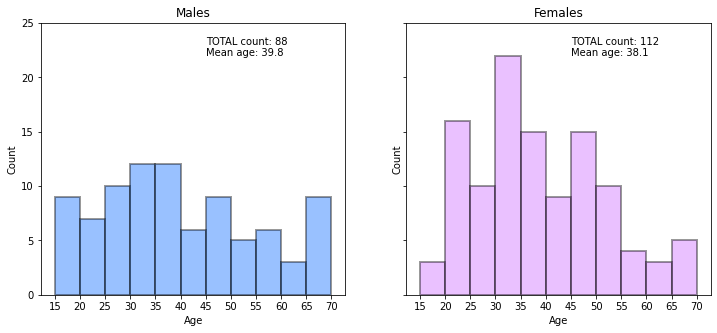

In [6]:
males_age = mall_data[mall_data['Gender'] == 'Male']['Age']   # subset with males age
females_age = mall_data[mall_data['Gender'] == 'Female']['Age']   # subset with females age

age_bins = range(15, 75, 5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

  - 남성 고객의 나이가 여성 고객의 나이에 비해 약간 더 높은 것으로 보인다.
  - 남성 고객의 경우, 여성 고객에 비해 비교적 나이대가 균일하게 분포하고 있음을 확인할 수 있다.

In [7]:
print('Kolmogorov-Smirnov test p-value : {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolmogorov-Smirnov test p-value : 0.49


  - p-value가 0.49로 매우 크므로, 두 그룹 사이의 나이는 크게 차이나지 않음을 알 수 있다.

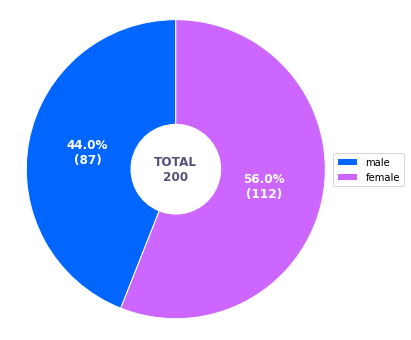

In [8]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

  - 여성 고객이 남성 고객에 비해 약간 더 많은 것을 확인할 수 있다.

##### b. Annual income

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


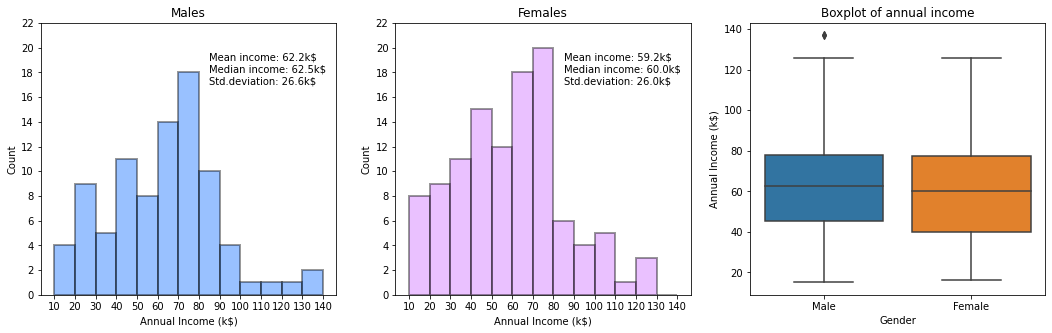

In [9]:
males_income = mall_data[mall_data['Gender'] == 'Male']['Annual Income (k$)']   # subset with males income
females_income = mall_data[mall_data['Gender'] == 'Female']['Annual Income (k$)']   # subset with females income

my_bins = range(10, 150, 10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
sns.distplot(males_income, bins = my_bins, kde = False, color = '#0066ff', ax = ax1,
             hist_kws = dict(edgecolor = 'k', linewidth = 2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0, 24, 2))
ax1.set_ylim(0, 22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85, 19, 'Mean income: {:.1f}k$'.format(males_income.mean()))
ax1.text(85, 18, 'Median income: {:.1f}k$'.format(males_income.median()))
ax1.text(85, 17, 'Std.deviation: {:.1f}k$'.format(males_income.std()))

# females histogram
sns.distplot(females_income, bins = my_bins, kde = False, color = '#cc66ff', ax = ax2,
             hist_kws = dict(edgecolor = 'k', linewidth = 2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0, 24, 2))
ax2.set_ylim(0, 22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85, 19, 'Mean income: {:.1f}k$'.format(females_income.mean()))
ax2.text(85, 18, 'Median income: {:.1f}k$'.format(females_income.median()))
ax2.text(85, 17, 'Std.deviation: {:.1f}k$'.format(females_income.std()))

# boxplot
sns.boxplot(x = 'Gender', y = 'Annual Income (k$)', data = mall_data, ax = ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

  - 남성 고객의 평균 수입이 더 높다.
  - 연간 수입의 중간값 역시 남성 고객이 더 높다.
  - 두 그룹의 표준편차는 거의 동일하다.

In [10]:
print('Kolmogorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolmogorov-Smirnov test p-value: 0.78


  - p-value가 0.78로 매우 크므로, 두 그룹 사이에는 유의한 연봉 차이가 없는 것으로 보인다.

##### c. Spending score

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


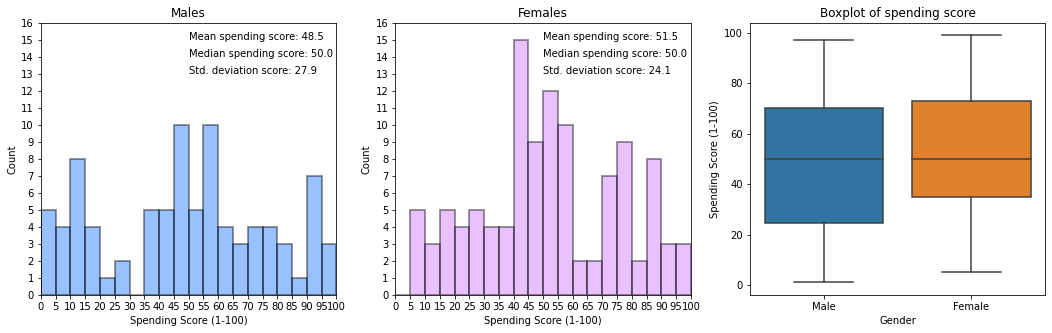

In [11]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

  - 여성의 소비율이 남성의 소비율보다 높다.

In [12]:
print('Kolmogorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolmogorov-Smirnov test p-value: 0.29


  - p-value가 0.29로 크기 때문에 두 그룹 사이에 유의한 소비율 차이가 없다고 볼 수도 있지만, 앞서 확인한 나이나 연간 수입에 비해서는 비교적 작은 p-value 값을 가지므로 두 그룹 사이에 유의한 소비율의 차이가 없다고 단언하기는 어렵다.

  - 다음으로 모든 연령대에 대해 median income 값을 구해보자.

In [13]:
medians_by_age_group = mall_data.groupby(['Gender', pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace = True)

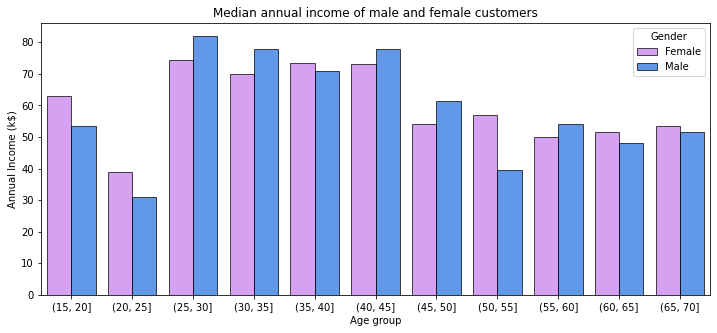

In [14]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(x = 'Age_group', y = 'Annual Income (k$)', hue = 'Gender',
            data = medians_by_age_group, palette = ['#cc66ff','#0066ff'],
            alpha = 0.7, edgecolor = 'k', ax = ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

  - 25-45세까지의 고객들의 수입이 가장 많다.
  - 성별 간의 차이가 가장 많이 벌어지는 나이대는 25-30, 50-55세이다.

### **3.2 Correlations**
  - Numerical 변수들 사이의 상관관계를 알아보자.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


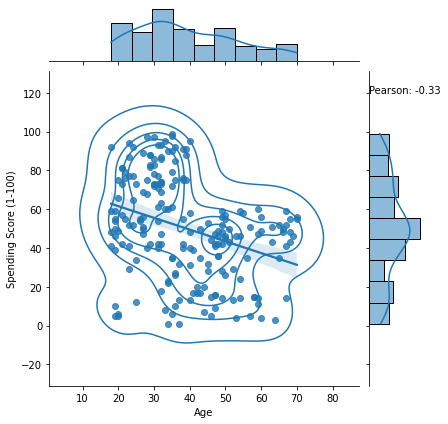

In [15]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])
jp = (sns.jointplot('Age', 'Spending Score (1-100)', data = mall_data, kind = 'reg')).plot_joint(sns.kdeplot, zorder = 0, n_levels = 6)

plt.text(0, 120, 'Pearson: {:.2f}'.format(corr))
plt.show()

##### a. Age vs. Annual income

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


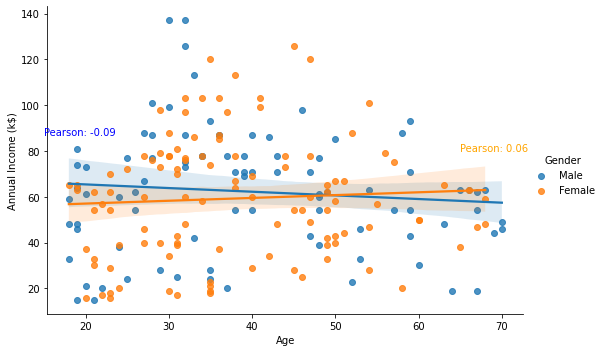

In [16]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data = mall_data, hue = 'Gender', aspect = 1.5)

plt.text(15, 87, 'Pearson: {:.2f}'.format(corr1), color = 'blue')
plt.text(65, 80, 'Pearson: {:.2f}'.format(corr2), color = 'orange')

plt.show()

  - 남성, 여성 그룹 모두 나이와 연간 수입 사이에는 유의한 상관관계가 존재하지 않는 것으로 나타난다. 

##### b. Age vs. Spending Score

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


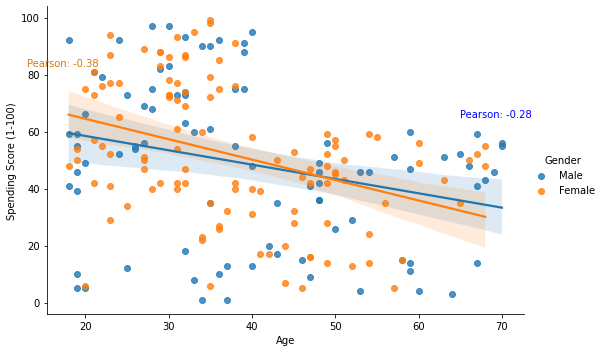

In [17]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data = mall_data, hue = 'Gender', aspect = 1.5)

plt.text(65, 65, 'Pearson: {:.2f}'.format(corr1), color = 'blue')
plt.text(13, 83, 'Pearson: {:.2f}'.format(corr2), color = '#d97900')

plt.show()

  - 두 그룹 모두 나이와 소비율 사이에 약한 음의 상관관계가 존재한다.(<0.5)

##### c. Annual Income vs. Spending Score 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


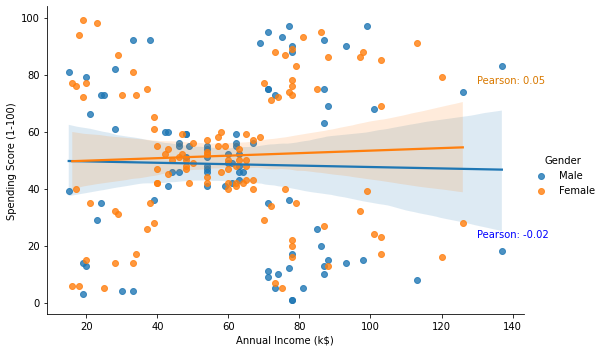

In [18]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data = mall_data, hue = 'Gender',
          aspect = 1.5)

plt.text(130, 23, 'Pearson: {:.2f}'.format(corr1), color = 'blue')
plt.text(130, 77, 'Pearson: {:.2f}'.format(corr2), color = '#d97900')

plt.show()

  - 두 그룹(남성/여성) 모두 연간 수입과 소비율 사이에는 상관관계가 존재하지 않음을 확인할 수 있다.

---

## **4. Clustering**
  - 세 가지 clustering 알고리즘 적용
    1. `K-Means`
    2. `DBSCAN`
    3. `Affinity Propagation`

### **4.1 K-Means**

#### 4.1.1 Description
  - `3 main steps` in K-Means algorithm
    1. Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.
    2. Calculate samples distances to groups' central points (centroids) and assign the nearest samples to their cluster.
    3. The third step is to calculate newly created (updated) cluster centroids.
    4. Then repeat step 2 and 3 until the algorithm converges.

  - `3 main parameters` of the K-Means algorithm
    1. Initialisation criteria
      - `k-means++`
    2. Number of clusters
      - cluster의 개수를 정하는 것이 해당 알고리즘에서 가장 까다로운 부분이다.
      - 가장 널리 사용되는 것이 `elbow method` 또는 `silhouette score`이다.
      - 그외에도 적절한 cluster의 개수를 설정하는 여러 방법들이 존재한다.
        - MML(Minimum Message Length)
        - MDL(Minimum Description Length)
        - BIC(Bayes Information Criterion)
        - AIC(Akaike Information Criterion)
        - Dirichlet Process
        - Gap statistics 
    3. A distance matric (사이킷런 패키지에서는 필요하지 않음)
      - 서로 다른 샘플 사이의 거리를 계산하는 방법은 여러 가지가 있다.
      - 그 중 가장 널리 사용되는 것은 `Euclidean distance`이다.

#### 4.1.2 Use case - customers segmentation

In [19]:
from sklearn.cluster import KMeans
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

  - Clustering을 위해 numerical 변수들만을 사용한다.

In [20]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]   # subset with numeric variables only

  - 적절한 cluster의 개수를 찾기 위해, elbow method를 사용한다.
  - Elbow method를 사용하기 위해, 2-10개 사이의 cluster들의 이너샤를 계산한다.
  - 이너샤 그래프에서 꺾이는 부분, 즉 elbow가 형성되는 지점의 cluster의 개수가 바로 최적의 cluster 개수이다.

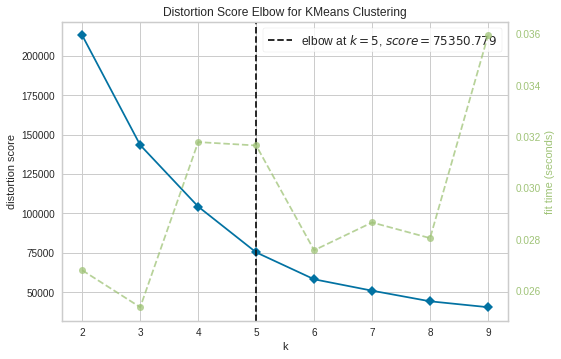

In [21]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(model, k = (2, 10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

  - 그래프 상에서 명확한 elbow 지점은 존재하지 않는 것으로 보인다.
  - 알고리즘은 5개의 cluster가 적절하다고 판단하였으므로, 5 또는 6개의 cluster를 사용하는 것이 적절해 보인다.

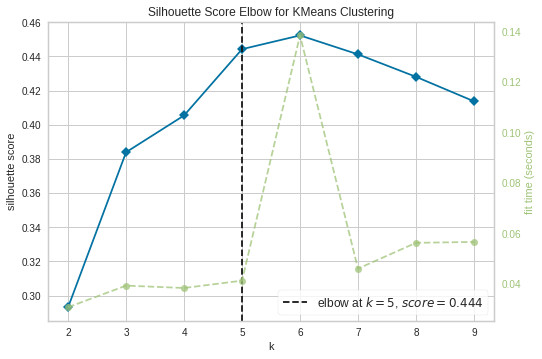

In [22]:
model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(model, k = (2, 10), metric = 'silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

  - 실루엣 점수 역시 5 또는 6개의 cluster를 가장 적절한 선택지로 제안한다.
  - 따라서 5개의 cluster와 6개의 cluster를 비교해보고자 한다.

##### a. 5 Clusters

In [23]:
KM_5_clusters = KMeans(n_clusters = 5, init = 'k-means++').fit(X_numerics)    # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:, 'Cluster'] = KM_5_clusters.labels_     # append labels to points

In [55]:
KM5_clustered.head()

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,0
1,21,15,81,3
2,20,16,6,0
3,23,16,77,3
4,31,17,40,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


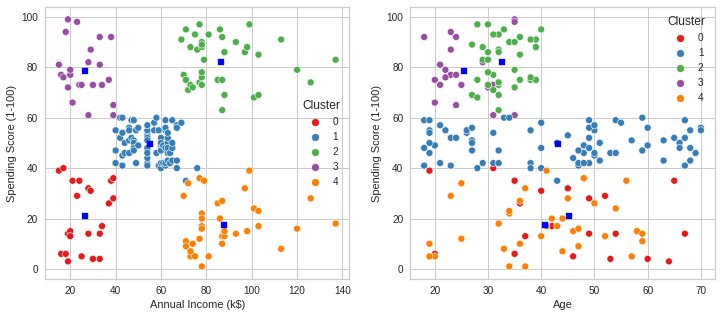

In [25]:
fig1, (axes) = plt.subplots(1, 2, figsize = (12, 5))

scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data = KM5_clustered,
                         hue = 'Cluster', ax = axes[0], palette = 'Set1', legend = 'full')

sns.scatterplot('Age', 'Spending Score (1-100)', data = KM5_clustered, hue = 'Cluster',
                palette = 'Set1', ax = axes[1], legend = 'full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:, 1], KM_5_clusters.cluster_centers_[:, 2],
                marker = 's', s = 40, c = 'blue')
axes[1].scatter(KM_5_clusters.cluster_centers_[:, 0], KM_5_clusters.cluster_centers_[:, 2],
                marker = 's', s = 40, c = 'blue')
plt.show()

  - K-Means 알고리즘은 다음과 같이 총 5개의 cluster를 형성하였다.(왼쪽 그래프)
    - 낮은 annual income & 높은 spending score(index = 3)
    - 낮은 annual income & 낮은 spending score(index = 4)
    - 중간 annual income & 중간 spending score(index = 2)
    - 높은 annual income & 높은 spending score(index = 0)
    - 높은 annual income & 낮은 spending score(index = 1)

  - 반면 age와 spending score를 기준으로 했을 때는 명확히 구별되는 cluster가 존재하지 않는 것으로 나타났다.(오른쪽 그래프) 

In [26]:
# Sizes of the clusters
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ['KM_size']
KM_clust_sizes

,KM_size
Cluster,
0,23
1,79
2,39
3,23
4,36


  - 가장 큰 cluster는 2번째 cluster로, 80개의 샘플이 여기에 포함된다.

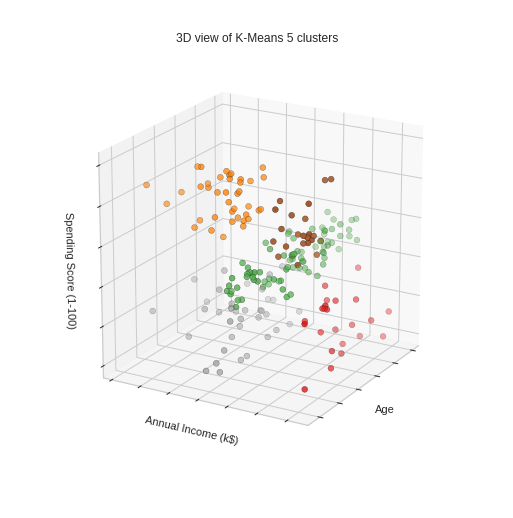

In [27]:
# 3D View of K-Means 5 clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [28]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

  - 각 cluster가 얼마나 잘 분류되었는지 알아보기 위해 Silhouette plot을 이용한다.

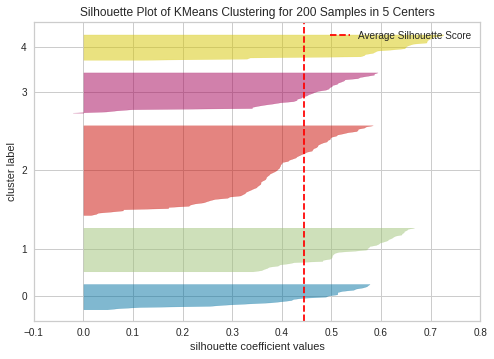

In [29]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters = 5, random_state = 0)
visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

##### b. 6 Clusters

In [30]:
KM_6_clusters = KMeans(n_clusters = 6, init = 'k-means++').fit(X_numerics)    # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:, 'Cluster'] = KM_6_clusters.labels_     # append labels to points

In [56]:
KM6_clustered.head()

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,0
1,21,15,81,5
2,20,16,6,0
3,23,16,77,5
4,31,17,40,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



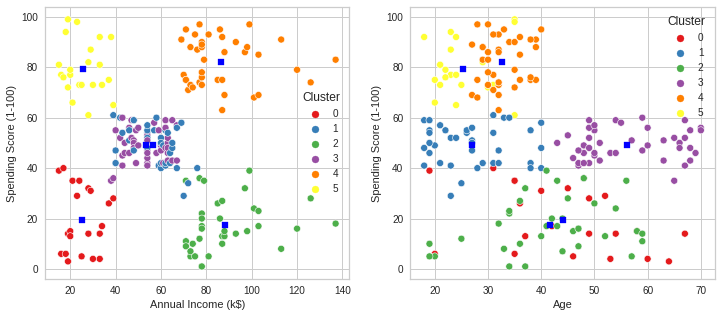

In [31]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

  - K-Means 알고리즘은 다음과 같이 총 6개의 cluster를 형성하였다.(왼쪽 그래프)
    - 낮은 annual income & 높은 spending score(index = 5)
    - 낮은 annual income & 낮은 spending score(index = 4)
    - 높은 annual income & 높은 spending score(index = 1)
    - 높은 annual income & 낮은 spending score(index = 2)
    - 중간 annual income & 중간 spending score를 가진 연령대가 낮은 고객(index = 3) 
    - 중간 annual income & 중간 spending score를 가진 연령대가 높은 고객(index = 0)

  - 반면 age와 spending score를 기준으로 했을 때는 명확히 구별되는 cluster가 존재하지 않는 것으로 나타났다.(오른쪽 그래프) 

In [32]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ['KM_size']
KM6_clust_sizes

,KM_size
Cluster,
0,21
1,38
2,35
3,45
4,39
5,22


In [33]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

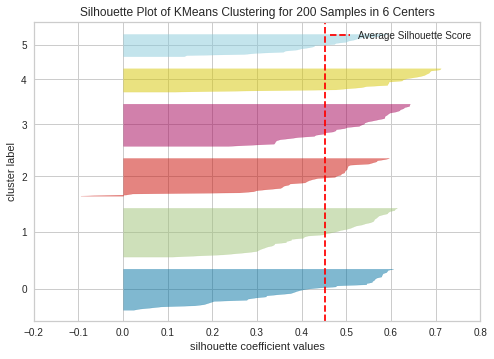

In [34]:
# Silhouette plot 확인
model = KMeans(n_clusters = 6, random_state = 0)
visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

### **4.2 DBSCAN**



#### 4.2.1 Description
  - Core idea of DBSCAN
    - Concept of "dense regions"
    - Natural clusters are composed of densely located points.
  
  - `Two parameters` for DBSCAN algorithm
    1. `Epsilon`, ϵ - distance
    2. `MinPts` - Minimum number of points within distance Epsilon

  - Dense Region
    - Created by a minimum number of points within distance between all of them, epsilon.
    - Points which are within this distance, but not close to minimum number of other points are treated as "border points".
    - Remaining ones are "noise" or "outliers".

  - 이해를 돕기 위해 아래의 그림을 살펴보자.

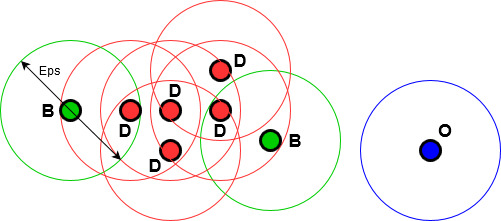

  1. Red points : dense region
    - dense region의 경우, 모든 샘플들이 입실론 반경 이내에 3개 이상의 샘플들을 포함하고 있다.
  2. Green points : border points
    - 입실론 반경 이내에 하나 이상의 샘플을 포함하고 있으나, 3개 미만인 경우에 해당한다.
  3. Blue point : outlier
    - 입실론 반경 이내에 다른 샘플이 하나도 포함되지 않는 경우에 해당한다. 

  - DBSCAN 알고리즘의 장점
    1. Epsilon, MinPts 하이퍼파라미터에 기반하여 클러스터의 개수를 스스로 설정한다.
    2. 길쭉한 모양의 클러스터나 다른 클러스터에 둘러싸여 있는 클러스터도 구분이 가능하다(K-Means의 경우에는 불가능).
    3. 어떤 클러스터에도 속하지 않는 샘플들 또한 찾아낼 수 있다. 따라서 해당 알고리즘은 이상치 탐지에 용이하다.

  - DBSCAN 알고리즘의 단점
    1. 계산이 복잡하다.
    2. 군집 간의 밀도가 상이할 경우, 클러스터를 잘 구분해내지 못한다.

#### 4.2.2 Use case - customers segmentation

In [35]:
from sklearn.cluster import DBSCAN

  - DBSCAN의 2가지 하이퍼파라미터
    1. eps 
    2. min_samples

  - 임의로 최적의 값을 갖는 두 하이퍼파라미터를 찾는 것은 어려우므로, 최적의 조합을 찾기 위해 다음의 코드를 실행한다.

In [36]:
from itertools import product

eps_values = np.arange(8, 12.75, 0.25)    # eps values to be investigated
min_samples = np.arange(3, 10)            # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

  - DBSCAN의 경우 eps, min_samples 두 파라미터를 활용해 스스로 클러스터를 형성하므로, 형성된 클러스터의 개수를 확인해보자.

In [37]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
  DBS_clustering = DBSCAN(eps = p[0], min_samples = p[1]).fit(X_numerics)
  no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
  sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

  - 아래의 heatplot은 두 하이퍼파라미터 조합을 이용해 DBSCAN 알고리즘이 만들어 낸 클러스터의 개수를 나타낸다.

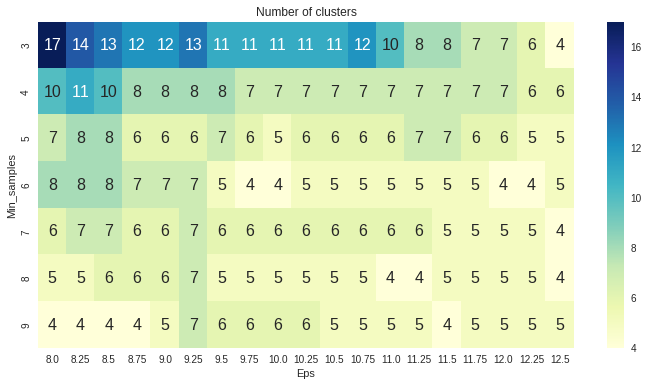

In [38]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns = ['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values = 'No_of_clusters', index = 'Min_samples', columns = 'Eps')

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(pivot_1, annot = True, annot_kws = {'size' : 16}, cmap = 'YlGnBu', ax = ax)
ax.set_title('Number of clusters')
plt.show()

  - 위의 heatplot을 통해 형성된 클러스터의 개수가 4개에서 17개로 매우 다양함을 알 수 있다.
  - 어떤 조합이 가장 최적인지를 알아내기 위해, 실루엣 점수를 확인해보자.

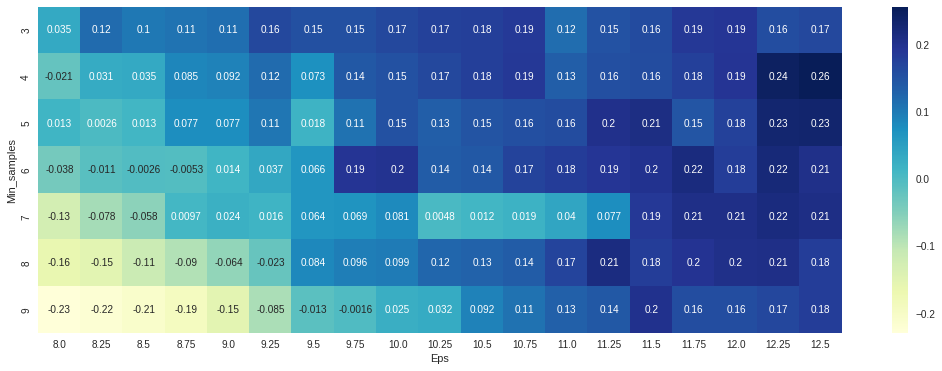

In [39]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns = ['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values = 'Sil_score', index = 'Min_samples', columns = 'Eps')

fig, ax = plt.subplots(figsize = (18, 6))
sns.heatmap(pivot_1, annot = True, annot_kws = {'size' : 10}, cmap = 'YlGnBu', ax = ax)
plt.show()

  - 실루엣 점수가 0.26으로 가장 높은 조합은 `eps = 12.5`, `min_samples = 4`인 경우이다.

In [40]:
DBS_clustering = DBSCAN(eps = 12.5, min_samples = 4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:, 'Cluster'] = DBS_clustering.labels_     # append labels to points

  - 클러스터의 크기를 확인해보자.

In [41]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ['DBSCAN_size']
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


  - 총 5개의 클러스터가 형성되었으며, 18개의 outlier(Cluster = -1)가 관찰되었다.
  - 또한 형성된 각 클러스터의 크기가 매우 상이한 것을 확인할 수 있다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



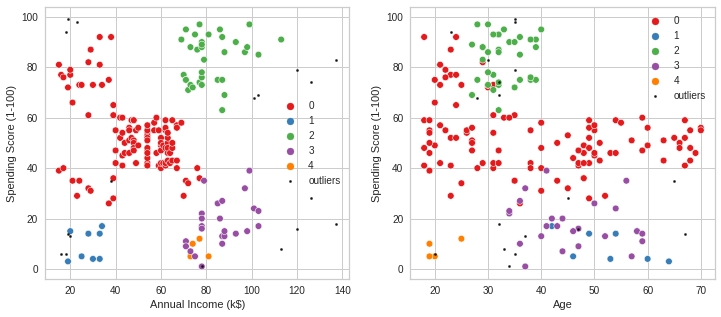

In [42]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster'] == -1]

fig2, (axes) = plt.subplots(1, 2, figsize = (12, 5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', 
                data = DBSCAN_clustered[DBSCAN_clustered['Cluster'] != -1],
                hue = 'Cluster', ax = axes[0], palette = 'Set1', legend = 'full', s = 45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data = DBSCAN_clustered[DBSCAN_clustered['Cluster'] != -1],
                hue = 'Cluster', palette = 'Set1', ax = axes[1], legend = 'full', s = 45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'],
                s = 5, label = 'outliers', c = 'k')
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], 
                s = 5, label = 'outliers', c = 'k')
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize = '10')
plt.setp(axes[1].get_legend().get_texts(), fontsize = '10')

plt.show()

  - 남색 점으로 표시된 outlier들을 확인할 수 있는데, 이는 거리와 min_samples 조건을 충족하지 못한 샘플들이라는 의미이다.

### **4.3 Affinity Propagation**

#### 4.3.1 Description
  - 정의
    - 모든 데이터가 특정한 기준에 따라 자신을 대표할 대표 데이터를 선택한다. 만약 스스로가 자기 자신을 대표하게 되면, 해당 샘플은 클러스터의 중심이 된다.

  - AP(Affinity Propagation)의 경우 알고리즘이 적절한 클러스터의 개수를 스스로 찾는다. 

  - 계산이 오래 걸리고 복잡하다는 단점이 있지만, 초기 중심점의 영향을 크게 받지 않는다는 큰 장점을 갖는다.

  - 하이퍼파라미터
    1. `Preference`
    2. `Damping factor`

#### 4.3.2 Use case - customers segmentation

In [43]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

In [44]:
no_of_clusters = []
preferences = range(-20000, -5000, 100) # arbitraty chosen range
af_sil_score = [] # silhouette scores

for p in preferences:
    AF = AffinityPropagation(damping = 0.55, preference = p, max_iter = 200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index = ['preference','clusters', 'sil_score']).T
af_results.sort_values(by = 'sil_score', ascending = False).head() # display only 5 best scores

,preference,clusters,sil_score
89,-11100.0,6.0,0.451491
78,-12200.0,6.0,0.451491
75,-12500.0,6.0,0.451440
58,-14200.0,6.0,0.451440
36,-16400.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



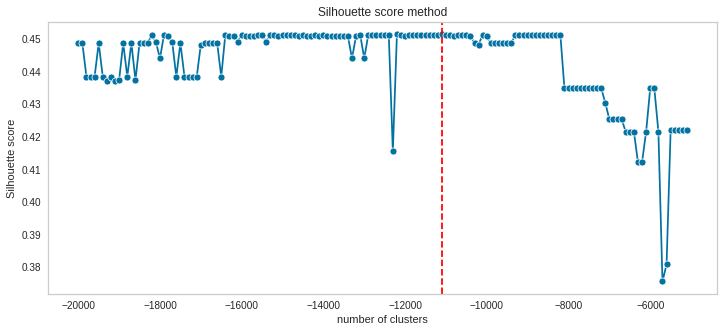

In [45]:
fig, ax = plt.subplots(figsize = (12, 5))
ax = sns.lineplot(preferences, af_sil_score, marker = 'o', ax = ax)
ax.set_title('Silhouette score method')
ax.set_xlabel('number of clusters')
ax.set_ylabel('Silhouette score')
ax.axvline(-11100, ls = '--', c = 'red')
plt.grid()
plt.show()

In [46]:
AF = AffinityPropagation(preference = -11100).fit(X_numerics)

In [47]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:, 'Cluster'] = AF.labels_     # append labels to points

In [48]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ['AF_size']
AF_clust_sizes

,AF_size
Cluster,
0,24
1,21
2,44
3,38
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



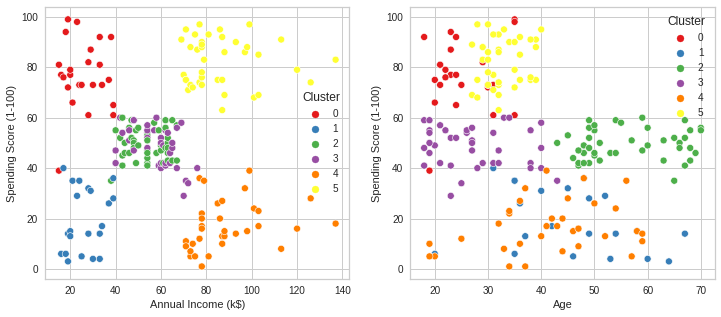

In [49]:
fig3, (ax_af) = plt.subplots(1, 2, figsize = (12, 5))

scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data = AF_clustered,
                         hue = 'Cluster', ax = ax_af[0], palette = 'Set1', legend = 'full')

sns.scatterplot('Age', 'Spending Score (1-100)', data = AF_clustered, hue = 'Cluster',
                palette = 'Set1', ax = ax_af[1], legend = 'full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize = '10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize = '10')
plt.show()

  - Affinity Propagation을 통해 형성된 클러스터는 K-Means를 통해 형성된 클러스터와 거의 유사하다.

---

## **5. Comparison and discussion**
  - 이제 3개의 알고리즘을 이용해 만들어낸 클러스터들을 비교해보자. 

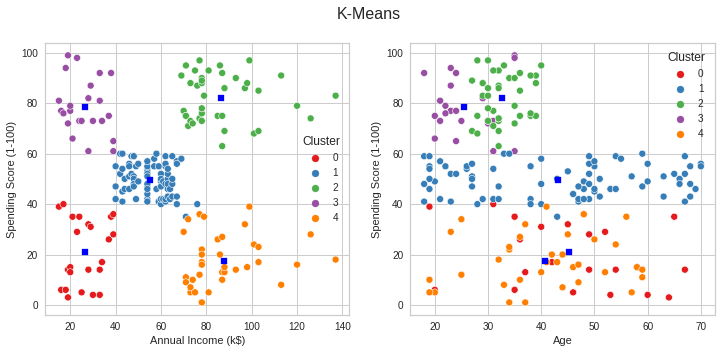

In [50]:
fig1.suptitle('K-Means', fontsize = 16)
fig1

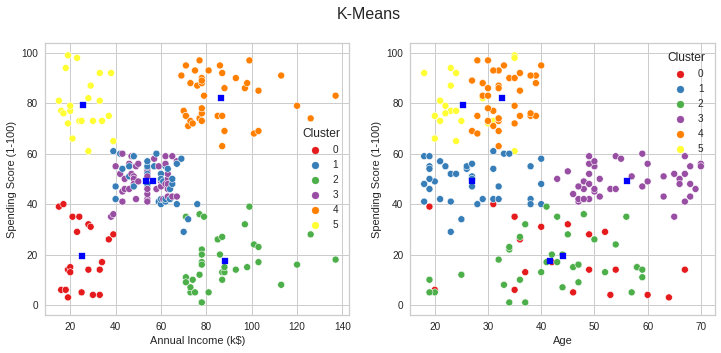

In [51]:
fig11.suptitle('K-Means', fontsize = 16)
fig11

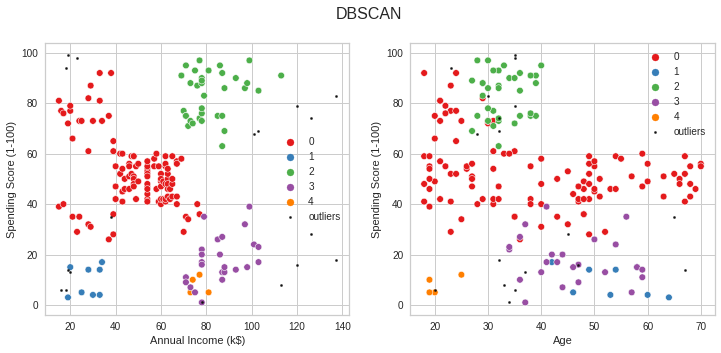

In [52]:
fig2.suptitle('DBSCAN', fontsize = 16)
fig2

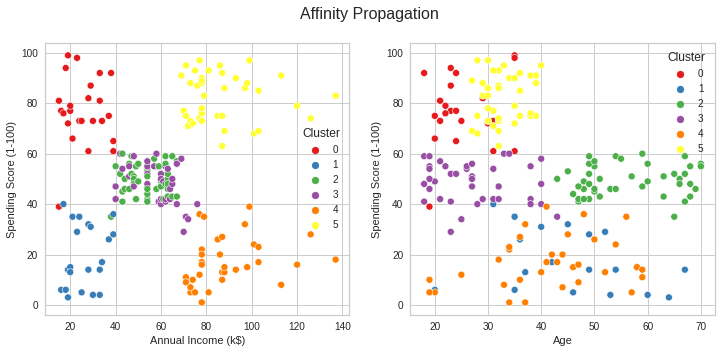

In [53]:
fig3.suptitle('Affinity Propagation', fontsize = 16)
fig3

  - 형성된 클러스터의 크기를 표로 나타내보면 아래와 같다.

In [54]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes], axis = 1, sort = False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,21.0,112.0,24.0
1,38.0,8.0,21.0
2,35.0,34.0,44.0
3,45.0,24.0,38.0
4,39.0,4.0,34.0
5,22.0,NaN,39.0


  - 위의 표를 통해 DBSCAN은 적절한 클러스터를 형성하는데 실패했음을 알 수 있다. 이는 DBSCAN 알고리즘이 샘플의 밀도에 따라 클러스터를 형성하려 하기 때문이다.
  - K-Means와 Affinity Propagation 알고리즘은 총 6개의 클러스터를 형성하였다.